In [1]:
import numpy as np
import pandas as pd

In [2]:
from catboost import CatBoostClassifier

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

In [6]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, roc_curve, auc
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

Общие функции

In [7]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 
    

In [8]:
def precision_recall_draw(y_test, y_pred, precision, recall, n=-1):
    plt.plot(recall[:n],precision[:n] )
    plt.title(' точность/полнота')
    plt.xlabel(' полнота')
    plt.ylabel(' точность')
    plt.grid('On')
    plt.show()

In [9]:
def roc_auc_curve_draw(y_test, y_pred):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_pred, pos_label=1)# C = 0.1
    roc_auc = auc(fpr, tpr)
    lw = 2

    plt.plot(fpr, 
             tpr, 
             lw=lw, 
             label="ROC curve (area = %0.2f)" % roc_auc)    
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    #plt.savefig("ROC.png")
    plt.show()
    return roc_auc

### Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

### Задание 1

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

Census Income Data Set был взят в качестве образца.  
Т.к. датасет не содержит названия колонок загрузка будет производится с headers=None.

In [10]:
names = ['age', 
'workclass',
'fnlwgt',
'education',
'education-num',
'marital-status',
'occupation',
'relationship',
'race',
'sex',
'capital-gain',
'capital-loss',
'hours-per-week',
'native-country',
'earnings']

In [11]:
df = pd.read_csv("adult.data", names=names, index_col=False)

In [12]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,earnings
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Анализ численных переменных.

In [13]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  earnings        32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Дополнительная проверка на NaN значения

In [16]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
earnings          0
dtype: int64

In [17]:
df['earnings'].value_counts()

 <=50K    24720
 >50K      7841
Name: earnings, dtype: int64

В качестве целевой переменной будет выступать колонка 14.

----------------

### Задание 2

3. сделать feature engineering

Преобразуем целевую переменную.

In [18]:
X = df.copy()

In [19]:
X.loc[X['earnings'] == ' <=50K', 'earnings'] = 0

In [20]:
X.loc[X['earnings'] == ' >50K', 'earnings'] = 1

In [21]:
X['earnings'].value_counts()

0    24720
1     7841
Name: earnings, dtype: int64

In [22]:
X['earnings'] = X['earnings'].astype('int8')

Подготовим списки категориальных инепрерывных переменных для последующего преобразования.

In [23]:
X.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'earnings'],
      dtype='object')

In [24]:
cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'native-country']

In [25]:
continious_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Посмотри внешний вид распределения непрерывных признаков

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>],
       [<AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'capital-gain'}>],
       [<AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

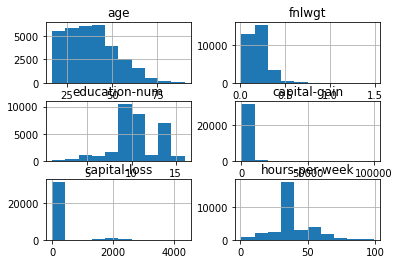

In [26]:
X[continious_features].hist()

Т.к. признаки имеют распределение далекое от симметричного, применим к ним преобразование квадратного корня.

In [27]:
for elem in continious_features:
    X['sqrt_' + elem] = np.sqrt(X[elem])

In [28]:
sqrt_features = ['sqrt_age', 'sqrt_fnlwgt', 'sqrt_education-num', 'sqrt_capital-gain', 'sqrt_capital-loss', 'sqrt_hours-per-week']

array([[<AxesSubplot:title={'center':'sqrt_age'}>,
        <AxesSubplot:title={'center':'sqrt_fnlwgt'}>],
       [<AxesSubplot:title={'center':'sqrt_education-num'}>,
        <AxesSubplot:title={'center':'sqrt_capital-gain'}>],
       [<AxesSubplot:title={'center':'sqrt_capital-loss'}>,
        <AxesSubplot:title={'center':'sqrt_hours-per-week'}>]],
      dtype=object)

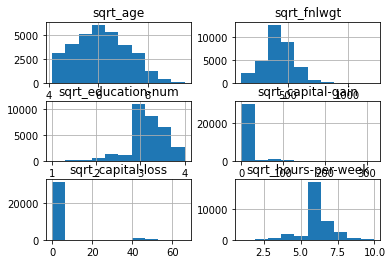

In [29]:
X[sqrt_features].hist()

Исходя из гистограмм выше, можно заключить, что данные приняли форму, больше похожую на нормальное распределение.

In [30]:
X.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,earnings,sqrt_age,sqrt_fnlwgt,sqrt_education-num,sqrt_capital-gain,sqrt_capital-loss,sqrt_hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.240810,6.115049,418.879840,3.144926,7.918279,2.006449,6.271175
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.427581,1.089892,119.659875,0.436037,31.858765,9.125818,1.053499
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000,4.123106,110.837719,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000,5.291503,343.259377,3.000000,0.000000,0.000000,6.324555
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000,6.082763,422.322152,3.162278,0.000000,0.000000,6.324555
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000,6.928203,486.878835,3.464102,0.000000,0.000000,6.708204
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000,9.486833,1218.484715,4.000000,316.226185,66.000000,9.949874


Подготовим датасеты для обучения.

In [31]:
y = X['earnings']

In [32]:
X = X.drop('earnings', axis = 1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=80)

Построим датафрэйм для сохранения результатов.

In [118]:
results = pd.DataFrame(columns = ['Model', 'Part', 'Recall', 'Precision', 'F1', 'RocAuc'])

In [119]:
results.head()

,Model,Part,Recall,Precision,F1,RocAuc


--------------------

### Задание 3

4. обучить любой классификатор (какой вам нравится)


Т.к. исходные набор данных содержит сравнительно большое количество переменных, вполне целесообразно использовать бибилиотеку CatBoost, ориентированную на работу с подобными датасетами.

Объчвдяем классификатор

In [35]:
cb_clf = CatBoostClassifier(iterations=20, 
                            depth = 2,
                            thread_count=2, 
                            random_state=42, 
                            silent=True)

Обучение модели

In [36]:
%%time
cb_clf.fit(X_train, 
           y_train, 
           cat_features=cat_features)

Wall time: 891 ms


Получение предсказаний вероятности

In [37]:
y_pred = cb_clf.predict_proba(X_test)

Расчет метрик

In [120]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, 1])

In [121]:
fscore = (2 * precision * recall) / (precision + recall)

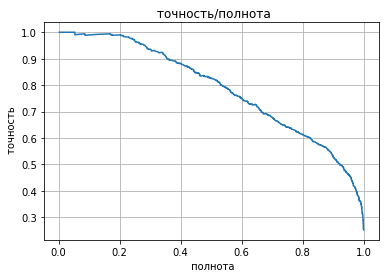

In [40]:
precision_recall_draw(y_test, y_pred[:, 1], precision, recall)

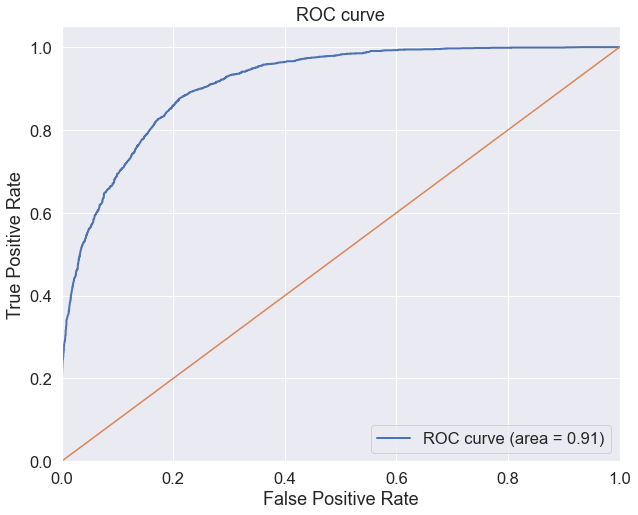

In [41]:
auc = roc_auc_curve_draw(y_test, y_pred[:, 1])

Сбор значений и добавление их в датасет

In [123]:
auc = roc_auc_score(y_test, y_pred[:, 1])

In [124]:
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],                                                                        
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.285613, F-Score=0.696, Precision=0.605, Recall=0.818


Внесем полученные данные в датасет с результатами

In [125]:
results = results.append({'Model':'CatBoost',                                 
                   'Part':'-', 
                   'Recall': recall[ix], 
                   'Precision':precision[ix], 
                   'F1':fscore[ix],
                    'RocAuc' : auc}
                  , ignore_index=True)

In [126]:
results.head()

,Model,Part,Recall,Precision,F1,RocAuc
0,CatBoost,-,0.818041,0.605263,0.695747,0.911637


----------

### Задание 4

5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть


In [49]:
y_pred.shape[0]

8141

In [50]:
y_test.shape[0]

8141

In [51]:
y_test.head()

22946    0
13044    0
828      0
9320     0
14156    0
Name: earnings, dtype: int8

Готовим данные к применению PU-learning

In [52]:
y_pu = pd.DataFrame(y_test)

In [53]:
y_pu.head()

,earnings
22946,0
13044,0
828,0
9320,0
14156,0


Получаем часть индексов позитивного класса

In [54]:
positive_indices = list(y_pu.loc[(y_pu['earnings']==1)].index)

In [55]:
np.random.shuffle(positive_indices)

In [56]:
pos_sample_len = int(np.ceil(0.25 * len(positive_indices)))

In [57]:
pu_indices = positive_indices[:pos_sample_len]

In [58]:
print(f'Using {pos_sample_len}/{len(positive_indices)} as positives and unlabeling the rest')

Using 485/1940 as positives and unlabeling the rest


In [59]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,sqrt_age,sqrt_fnlwgt,sqrt_education-num,sqrt_capital-gain,sqrt_capital-loss,sqrt_hours-per-week
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,6.244998,278.416954,3.605551,46.626173,0.0,6.324555
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,7.071068,288.636450,3.605551,0.000000,0.0,3.605551
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,6.164414,464.377002,3.000000,0.000000,0.0,6.324555
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,7.280110,484.480134,2.645751,0.000000,0.0,6.324555
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,5.291503,581.729318,3.605551,0.000000,0.0,6.324555


In [60]:
X_test_merged = X_test.merge(y_test, left_index=True, right_index=True)

Объединяем данные и результат назад в единый датасет

In [61]:
X_test_merged['class_test'] = -1

In [62]:
X_test_merged.at[pu_indices,'class_test'] = 1

Проверяем полученный результат

In [63]:
X_test_merged['class_test'].value_counts()

-1    7656
 1     485
Name: class_test, dtype: int64

In [154]:
X_test_merged.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,hours-per-week,native-country,sqrt_age,sqrt_fnlwgt,sqrt_education-num,sqrt_capital-gain,sqrt_capital-loss,sqrt_hours-per-week,earnings,class_test
22946,40,Federal-gov,189610,HS-grad,9,Divorced,Adm-clerical,Not-in-family,Black,Female,...,52,United-States,6.324555,435.442304,3.000000,0.0,0.0,7.211103,0,-1
13044,45,Private,27332,HS-grad,9,Divorced,Sales,Not-in-family,White,Female,...,40,United-States,6.708204,165.323924,3.000000,0.0,0.0,6.324555,0,-1
828,43,Private,233130,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Male,...,25,United-States,6.557439,482.835376,3.162278,0.0,0.0,5.000000,0,-1
9320,34,Self-emp-not-inc,123429,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,...,60,United-States,5.830952,351.324636,3.000000,0.0,0.0,7.745967,0,-1
14156,21,Private,44793,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Male,...,65,United-States,4.582576,211.643568,3.162278,0.0,0.0,8.062258,0,-1


-----------------------

### Задание 5

6. применить random negative sampling для построения классификатора в новых условиях

In [65]:
X_pu = X_test_merged.iloc[:, :-2]

In [66]:
y_pu_labeled = X_test_merged.iloc[:, :-1]

In [67]:
y_pu_positive = X_test_merged.iloc[:,-2]

Отделим истинные значения и класс для разметки

In [68]:
X_test_merged = X_test_merged.sample(frac=1)

In [69]:
neg_sample = X_test_merged[X_test_merged['class_test']==-1][:len(X_test_merged[X_test_merged['class_test']==1])]

In [70]:
sample_test = X_test_merged[X_test_merged['class_test']==-1][len(X_test_merged[X_test_merged['class_test']==1]):]

In [71]:
pos_sample = X_test_merged[X_test_merged['class_test']==1]

In [72]:
print(neg_sample.shape, pos_sample.shape)

(485, 22) (485, 22)


In [73]:
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

In [74]:
sample_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,hours-per-week,native-country,sqrt_age,sqrt_fnlwgt,sqrt_education-num,sqrt_capital-gain,sqrt_capital-loss,sqrt_hours-per-week,earnings,class_test
8279,36,Private,447346,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,...,50,United-States,6.000000,668.839293,3.000000,0.000000,0.000000,7.071068,1,1
11066,34,Private,164190,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,38,United-States,5.830952,405.203653,3.162278,0.000000,43.611925,6.164414,1,1
12173,55,Local-gov,99131,HS-grad,9,Married-civ-spouse,Prof-specialty,Other-relative,White,Female,...,40,United-States,7.416198,314.850758,3.000000,0.000000,47.391982,6.324555,1,1
8741,41,Self-emp-inc,253060,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,...,45,United-States,6.403124,503.050693,3.605551,87.681241,0.000000,6.708204,1,1
5499,56,Private,175127,HS-grad,9,Divorced,Craft-repair,Unmarried,White,Male,...,35,United-States,7.483315,418.481780,3.000000,0.000000,0.000000,5.916080,0,-1


Назначаем еще один классификатор.

In [75]:
cb_clf_pu = CatBoostClassifier(iterations=20, 
                            depth = 2,
                            thread_count=2, 
                            random_state=42, 
                            silent=True)

In [76]:
sample_train.loc[sample_train['class_test']==-1,'class_test']=0

In [77]:
cat_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

Проводим обучение модели

In [78]:
%%time
cb_clf_pu.fit(sample_train.iloc[:,:-2], 
              sample_train.iloc[:,-1], 
              cat_features=cat_features)

Wall time: 370 ms


Получение предсказаний вероятностей и с окончательным выбором класса.

In [79]:
y_predict_proba = cb_clf_pu.predict_proba(sample_test.iloc[:,:-2])

In [80]:
y_predict_class = cb_clf_pu.predict(sample_test.iloc[:,:-2])

In [81]:
evaluate_results(sample_test.iloc[:,-2], y_predict_class)

Classification results:
f1: 59.69%
recall: 80.16%
precision: 47.55%


In [82]:
y_pu_test = sample_test.iloc[:,-2]

Расчет метрик и вывод результатов в графической форме

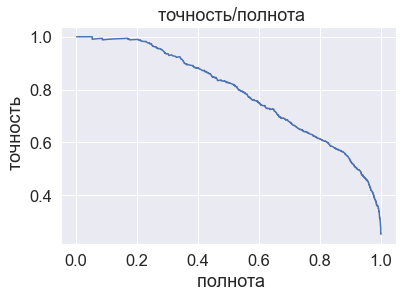

In [83]:
precision_recall_draw(y_pu_test, y_predict_proba, precision, recall)

In [127]:
precision, recall, thresholds = precision_recall_curve(y_pu_test, y_predict_proba[:, 1])

In [128]:
fscore = (2 * precision * recall) / (precision + recall)

In [129]:
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.557094, F-Score=0.621, Precision=0.551, Recall=0.710


In [130]:
auc = roc_auc_score(y_pu_test, y_predict_proba[:, 1])

In [131]:
auc

0.8860353127004911

In [132]:
results = results.append({'Model':'PU',                                 
                   'Part':0.25, 
                   'Recall': recall[ix], 
                   'Precision':precision[ix], 
                   'F1':fscore[ix],
                    'RocAuc' : auc}
                  , ignore_index=True)

In [133]:
results

,Model,Part,Recall,Precision,F1,RocAuc
0,CatBoost,-,0.818041,0.605263,0.695747,0.911637
1,PU,0.25,0.710355,0.551124,0.620690,0.886035


### Задание 6

7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)

Для данной модели (Catboost) качество по основным метрикам с PU learning ниже, чем без него для доли в 25%.

### Задание 7

8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

Объявляем классификатор

In [141]:
cb_clf_pu_rat = CatBoostClassifier(iterations=20, 
                            depth = 2,
                            thread_count=2, 
                            random_state=42, 
                            silent=True)

Назначаем ряд соотношений по которым будет выполняться выборка.

In [138]:
ratio = np.linspace(0.1, 0.9, 9)
ratio

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

Выполняем функции в цикле для каждого элемента из ряда.

In [142]:
for elem in ratio:
    y_pu = pd.DataFrame(y_test)
    positive_indices = list(y_pu.loc[(y_pu['earnings']==1)].index)
    np.random.shuffle(positive_indices)
    # part is set here
    pos_sample_len = int(np.ceil(elem * len(positive_indices)))
    pu_indices = positive_indices[:pos_sample_len]

    X_test_merged = X_test.merge(y_test, left_index=True, right_index=True)
    X_test_merged['class_test'] = -1
    X_test_merged.at[pu_indices,'class_test'] = 1

    X_pu = X_test_merged.iloc[:, :-2]
    y_pu_labeled = X_test_merged.iloc[:, :-1]
    y_pu_positive = X_test_merged.iloc[:,-2]

    X_test_merged = X_test_merged.sample(frac=1)
    neg_sample = X_test_merged[X_test_merged['class_test']==-1][:len(X_test_merged[X_test_merged['class_test']==1])]
    sample_test = X_test_merged[X_test_merged['class_test']==-1][len(X_test_merged[X_test_merged['class_test']==1]):]
    pos_sample = X_test_merged[X_test_merged['class_test']==1]

    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)
    sample_train.loc[sample_train['class_test']==-1,'class_test']=0

    # training of model
    cb_clf_pu.fit(sample_train.iloc[:,:-2], 
              sample_train.iloc[:,-1], 
              cat_features=cat_features)
 
    #obtaining predictions
    y_predict_proba = cb_clf_pu.predict_proba(sample_test.iloc[:,:-2])
    y_pu_test = sample_test.iloc[:,-2]
    
    #calculation of metrics
    precision, recall, thresholds = precision_recall_curve(y_pu_test, y_predict_proba[:, 1])
    fscore = (2 * precision * recall) / (precision + recall)
    auc = roc_auc_score(y_pu_test, y_predict_proba[:, 1])

    ix = np.argmax(fscore)

    #adding metrics to result dataframe
    results = results.append({'Model':'PU-ratio',                                 
                       'Part':elem, 
                       'Recall': recall[ix], 
                       'Precision':precision[ix], 
                       'F1':fscore[ix],
                        'RocAuc' : auc}
                      , ignore_index=True)
    

Вывод датафрэйма с результатами

In [143]:
results

,Model,Part,Recall,Precision,F1,RocAuc
0,CatBoost,-,0.818041,0.605263,0.695747,0.911637
1,PU,0.25,0.710355,0.551124,0.620690,0.886035
2,PU-ratio,0.1,0.792920,0.521334,0.629066,0.874815
3,PU-ratio,0.2,0.750678,0.532181,0.622822,0.885030
4,PU-ratio,0.3,0.669841,0.563794,0.612260,0.890660
5,PU-ratio,0.4,0.683044,0.530292,0.597053,0.892649
6,PU-ratio,0.5,0.614057,0.529224,0.568493,0.900509
7,PU-ratio,0.6,0.647328,0.500000,0.564205,0.908282
8,PU-ratio,0.7,0.552174,0.466912,0.505976,0.898525
9,PU-ratio,0.8,0.422297,0.520833,0.466418,0.901772


#### Выводы
Судя по полученным результатам, качетсво предсказаний снижается по мере увеличения выбранной величины.  
Если верить полученным результатам, применение PU обучения нецелесообразно для данного датасета и при даннй модели.  
Наилучшее качество предсказания в данном случае получается при применении "чистой" модели.  
Данный вывод применим исключительно к данному датасету.